# 모듈 불러오기

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F                 # 딥러닝에 자주 사용되는 함수가 포함된 모듈
import torch.optim as optim                     # 가중치 추정에 필요한 최적화 알고리즘을 포함한 모둘
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
# %matplotlib inline                              # 주피터 노트북 사용시 추가

# 분석 환경 설정

In [28]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")

print("Current cuda device is", device)
# GPU 사용 : Current cuda device is cuda
# CPU 사용 : Current cuda device is cpu

Current cuda device is cuda


# HyperParameter 지정

In [49]:
batch_size = 50         # 모델 가중치를 한 번 업데이트시킬 때 사용되는 샘플 단위 개수
epoch_num = 15          # 학습 데이터를 모두 사용하여 학습하는 기본 단위 횟수
learning_rate = 0.0001  # 가중치 업데이트의 정도

# MNIST 데이터 불러오기

In [50]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())

# MNIST 데이터 확인하기

In [51]:
print(len(train_data))
print(len(test_data))

60000
10000


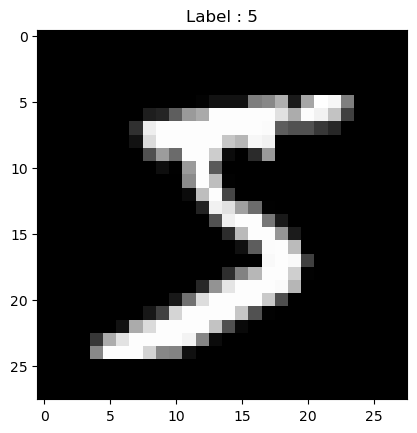

In [52]:
image, label = train_data[0]

plt.imshow(image.squeeze(0).numpy(), cmap = 'gray')
plt.title('Label : %s' %label)
plt.show()

# 미니 배치 구성하기

In [53]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

first_batch = train_loader.__iter__().__next__()

print('{:15s} | {:<25s} | {}'.format('name','type','size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch','',len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]',str(type(first_batch[0])),first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]',str(type(first_batch[1])),first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


# CNN 구조 설계하기

In [54]:
class CNN(nn.Module):
    def __init__(self): #모델에서 사용되는 가중치를 정의
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        X = F.max_pool2d(x, 2)
        x = self.dropout1(X)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x - self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# Optimizer 및 손실 함수 정의

In [55]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

# 설계한 CNN 모형 확인하기

In [56]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 모델 학습

In [57]:
model.train()
i = 0
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

Train Step: 0	Loss: 2.310
Train Step: 1000	Loss: 0.276
Train Step: 2000	Loss: 0.039
Train Step: 3000	Loss: 0.193
Train Step: 4000	Loss: 0.038
Train Step: 5000	Loss: 0.024
Train Step: 6000	Loss: 0.087
Train Step: 7000	Loss: 0.020
Train Step: 8000	Loss: 0.016
Train Step: 9000	Loss: 0.003
Train Step: 10000	Loss: 0.006
Train Step: 11000	Loss: 0.025
Train Step: 12000	Loss: 0.004
Train Step: 13000	Loss: 0.012
Train Step: 14000	Loss: 0.100
Train Step: 15000	Loss: 0.000
Train Step: 16000	Loss: 0.000
Train Step: 17000	Loss: 0.009


# 모델 평가

In [47]:
model.eval()
correct = 0

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
    
print('Test set: Accuracy: {:.2f}%'.format(100 * correct / len(test_loader.dataset)))

Test set: Accuracy: 98.91%
